## Python libraries

First, let's import the necessary Python libraries and configure the environment:

In [1]:
import numpy as np
#from scipy.signal import butter, filtfilt
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
#import seaborn as sns
#sns.set_context("notebook", font_scale=1.3,
#                rc={'lines.linewidth': 1.5, 'lines.markersize': 14, 'axes.titlesize': 'x-large'})
#matplotlib.rc('legend', numpoints=1, fontsize=14)
#import glob
import sys, os
sys.path.insert(1, r'./Functions')
# IPython widgets:
from IPython.display import display
import ipywidgets
from ipywidgets import FloatProgress, interactive
import seaborn as sns

In [2]:
#!pip install version_information
%load_ext version_information
%version_information numpy, scipy, pandas, matplotlib, seaborn

Software versions
Python 3.8.8 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.22.0
OS Windows 10 10.0.22000 SP0
numpy 1.20.1
scipy 1.6.2
pandas 1.2.4
matplotlib 3.3.4
seaborn 0.11.1
Fri Oct 07 13:26:42 2022 Hora oficial do Brasil

## Meta data

The file `PDSinfo.txt` contains meta data about the subjects and the experimental trials. The file has a header plus 588 rows per 29 columns (there are 12 rows for each of the 49 subjects).   
Let's use the power of the [pandas](http://pandas.pydata.org/) library to load and explore the meta data:

In [3]:
# GitHub URL:
#path2 = 'C:\Users\ferna\Downloads\IC- dados\Dados'
# local directory:
path2 = r'C:\\Users\\ferna\\Downloads\\IC- dados\\Dados'
fname = os.path.join(path2, 'PDSinfo.txt')
PDSinfo = pd.read_csv(fname, sep='\t', header=0, index_col=None, engine='c', encoding='utf-8')
print(fname)
print("Information of %s subjects loaded (%s rows, %s columns)."
      %(len(pd.unique(PDSinfo.Subject)), PDSinfo.shape[0], PDSinfo.shape[1]))

C:\\Users\\ferna\\Downloads\\IC- dados\\Dados\PDSinfo.txt
Information of 49 subjects loaded (588 rows, 29 columns).


In [4]:
a=PDSinfo[PDSinfo['Subject']==44].index.tolist()
e=PDSinfo[PDSinfo['Subject']==44].index.tolist()[2]
print(a)
print(e)

[516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527]
518


Here are the first 12 rows and first 10 columns of meta data:

## COP and COG displacements

## For Every Subject

COP = alfa*angulo + beta* derivada

In [5]:
from sklearn.linear_model import LinearRegression
fs = 100 # Hz
COPX = np.zeros((49, 60*fs-30))
COPZ = np.zeros((49, 60*fs-30))

COPXreal = np.zeros((49, 60*fs-30))
COPZreal = np.zeros((49, 60*fs-30))

d1x = np.zeros((49, 60*fs-30))
d2x = np.zeros((49, 60*fs-30))

d1z = np.zeros((49, 60*fs-30))
d2z = np.zeros((49, 60*fs-30))

matrizangx = np.zeros((49, 60*fs-30))
matrizangz = np.zeros((49, 60*fs-30))

alpha = np.zeros((49, 60*fs-30))
for s in range (1,50):
    a = PDSinfo[PDSinfo['Subject']==s].index.tolist()[2]
    
    fname_grf = os.path.join(path2, PDSinfo.Trial[a] + 'grf' + '.txt') 
    fname_mkr = os.path.join(path2, PDSinfo.Trial[a] + 'mkr' + '.txt')
    grf = pd.read_csv(fname_grf, delimiter='\t', header=0, engine='c')
    mkr = pd.read_csv(fname_mkr, delimiter='\t', header=0, engine='c')
    COGX=mkr['COG_X']
    COGY=mkr['COG_Y']
    COGZ=mkr['COG_Z']
    mass=PDSinfo['Mass']
    d = np.sqrt(COGX**2+COGY**2+COGZ**2)
    angulox = np.arcsin(COGX/d)
    anguloz= np.arcsin(COGZ/d)
    sinx=np.sin(angulox)
    sinz=np.sin(anguloz)
    cosx=np.cos(angulox)
    cosz=np.cos(anguloz)
    tanx=np.tan(angulox)
    tanz=np.tan(anguloz)
    matrizangx[s-1,:] = angulox.values[30:]
    matrizangz[s-1,:] = anguloz.values[30:]
    
    
    Jb=(4/3)*(mass.values[s])*((d[30:])**2)
    t=grf['Time']
    dt=t[1]-t[0]

    d1x[s-1,:]=np.gradient(matrizangx[s-1,:],dt)
    d1z[s-1,:]=np.gradient(matrizangz[s-1,:],dt)

    d2x[s-1,:]=np.gradient(d1x[s-1,:],dt)
    d2z[s-1,:]=np.gradient(d1z[s-1,:],dt)
    
    COPX[s-1,:] = d.values[30:]*sinx.values[30:] + Jb/(mass.values[s]*9.8)*(sinx.values[30:]*d1x[s-1,:]**2-cosx.values[30:]*d2x[s-1,:])
    COPZ[s-1,:] = d.values[30:]*sinz.values[30:] + Jb/(mass.values[s]*9.8)*(sinz.values[30:]*d1z[s-1,:]**2-cosz.values[30:]*d2z[s-1,:])
    
    
    COPXreal[s-1,:]=grf['COPNET_X'].values[30:]
    COPZreal[s-1,:]=grf['COPNET_Z'].values[30:]
    
    x= np.vstack((COPX[[s-1],:],d2x[[s-1],:]))
    y= COPXreal[s-1,:]

    model=LinearRegression(fit_intercept=False)
    model.fit(x.T,y)
    #print(model.coef_) 
    
    #def reg_m(y, x):
        #ones = np.ones(len(x[0]))
        #X = sm.add_constant(np.column_stack((x[0], ones)))
        #for oi in x[1:]:
            #X = sm.add_constant(np.column_stack((oi, X)))
            #results = sm.OLS(y, x).fit()
            #return results
    #print(model.coef_)
    #print(reg_m(y, x.T).summary())
 
    #print(model.coef_)
    #x= (np.array([COPX[s-1,:],d2x[s-1,:]]))
    #y= COPXreal[s-1,:]
    #model=LinearRegression()
    #model.fit(x.T,y)
    #print(model.coef_) 
    #Histogramas
    #plt.figure()
    #hist=plt.hist(model.coef_[0], bins=50)
    #plt.title('Histograms of alpha'.format(s))
    #plt.show()
print(COGX)    

0       0.264040
1       0.264001
2       0.263961
3       0.263919
4       0.263876
          ...   
5995    0.251854
5996    0.251785
5997    0.251715
5998    0.251646
5999    0.251579
Name: COG_X, Length: 6000, dtype: float64


[0.226171 0.226215 0.22628  ... 0.239102 0.239199 0.239302]
[0.265622 0.265845 0.266072 ... 0.244288 0.244232 0.24418 ]
[0.228266 0.228242 0.22824  ... 0.210021 0.210067 0.210129]
[0.201201 0.201274 0.201328 ... 0.192306 0.192299 0.19228 ]
[0.226489 0.226548 0.226604 ... 0.212395 0.212387 0.212359]
[0.213573 0.213584 0.213602 ... 0.193228 0.193121 0.192987]
[0.21237  0.212326 0.212265 ... 0.188437 0.188492 0.18853 ]
[0.214675 0.214655 0.214664 ... 0.213194 0.213081 0.212961]
[0.208002 0.208001 0.207993 ... 0.213046 0.212957 0.21284 ]
[0.230632 0.230624 0.230612 ... 0.229226 0.229328 0.229441]
[0.24118  0.241489 0.241808 ... 0.21804  0.218075 0.21812 ]
[0.214241 0.214255 0.214287 ... 0.20103  0.200968 0.2009  ]
[0.224572 0.22452  0.224466 ... 0.226079 0.226128 0.22619 ]
[0.21678  0.216729 0.216662 ... 0.200695 0.200623 0.20055 ]
[0.195308 0.195519 0.195747 ... 0.190798 0.190699 0.190559]
[0.24953  0.249516 0.249508 ... 0.238421 0.238324 0.238209]
[0.207211 0.207277 0.20735  ... 0.188963

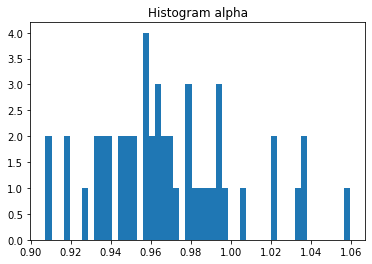

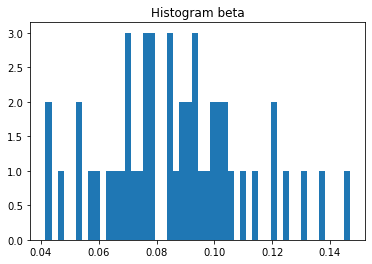

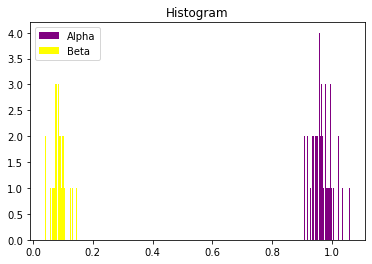

0.968254853833539
0.08722443052591325


In [6]:
from sklearn.linear_model import LinearRegression
fs = 100 # Hz
COPX = np.zeros((49, 60*fs-30))
COPZ = np.zeros((49, 60*fs-30))

COPXreal = np.zeros((49, 60*fs-30))
COPZreal = np.zeros((49, 60*fs-30))

d1x = np.zeros((49, 60*fs-30))
d2x = np.zeros((49, 60*fs-30))

d1z = np.zeros((49, 60*fs-30))
d2z = np.zeros((49, 60*fs-30))

matrizangx = np.zeros((49, 60*fs-30))
matrizangz = np.zeros((49, 60*fs-30))

alpha = []
beta=[]

for s in range (1,50):
    a = PDSinfo[PDSinfo['Subject']==s].index.tolist()[2]
    
    fname_grf = os.path.join(path2, PDSinfo.Trial[a] + 'grf' + '.txt') 
    fname_mkr = os.path.join(path2, PDSinfo.Trial[a] + 'mkr' + '.txt')
    grf = pd.read_csv(fname_grf, delimiter='\t', header=0, engine='c')
    mkr = pd.read_csv(fname_mkr, delimiter='\t', header=0, engine='c')
    COGX=mkr['COG_X']
    COGY=mkr['COG_Y']
    COGZ=mkr['COG_Z']
    mass=PDSinfo['Mass']
    d = np.sqrt(COGX**2+COGY**2+COGZ**2)
    angulox = np.arcsin(COGX/d)
    anguloz= np.arcsin(COGZ/d)
    sinx=np.sin(angulox)
    sinz=np.sin(anguloz)
    cosx=np.cos(angulox)
    cosz=np.cos(anguloz)
    tanx=np.tan(angulox)
    tanz=np.tan(anguloz)
    matrizangx[s-1,:] = angulox.values[30:]
    matrizangz[s-1,:] = anguloz.values[30:]
    
    Jb=(4/3)*(mass.values[s])*((d[30:])**2)
    t=grf['Time']
    dt=t[1]-t[0]

    d1x[s-1,:]=np.gradient(matrizangx[s-1,:],dt)
    d1z[s-1,:]=np.gradient(matrizangz[s-1,:],dt)
    
    

    d2x[s-1,:]=np.gradient(d1x[s-1,:],dt)
    d2z[s-1,:]=np.gradient(d1z[s-1,:],dt)
    
    COPX[s-1,:] = d.values[30:]*sinx.values[30:] + Jb/(mass.values[s]*9.8)*(sinx.values[30:]*d1x[s-1,:]**2-cosx.values[30:]*d2x[s-1,:])
    COPZ[s-1,:] = d.values[30:]*sinz.values[30:] + Jb/(mass.values[s]*9.8)*(sinz.values[30:]*d1z[s-1,:]**2-cosz.values[30:]*d2z[s-1,:])
    
    
    COPXreal[s-1,:]=grf['COPNET_X'].values[30:]
    COPZreal[s-1,:]=grf['COPNET_Z'].values[30:]
    
   
    
    x= np.vstack((COPX[[s-1],:],d2x[[s-1],:]))
    y= COPXreal[s-1,:]
    
    print(y)
   

    model=LinearRegression(fit_intercept=False)
    model.fit(x.T,y)
   
    alpha.append(model.coef_[0])
    beta.append(model.coef_[1])
    
#Histograma só alfa
plt.figure()
hist = plt.hist(alpha, bins=50)
plt.title('Histogram alpha')
plt.show()

#Histograma só beta
plt.figure()
hist2=plt.hist(beta, bins=50)
plt.title('Histogram beta')
plt.show()
#Histograma dos dois 
plt.figure()
hist = plt.hist(alpha, bins=50, color='purple',label='Alpha')
hist2=plt.hist(beta, bins=50, color='yellow',label='Beta')
plt.legend()
plt.title('Histogram')
plt.show()
alfamedia=np.mean(alpha)
betamedia=np.mean(beta)
print(alfamedia)
print(betamedia)

In [7]:
from sklearn.linear_model import LinearRegression
fs = 100 # Hz
COPX = np.zeros((49, 60*fs-30))
COPZ = np.zeros((49, 60*fs-30))

COPXreal = np.zeros((49, 60*fs-30))
COPZreal = np.zeros((49, 60*fs-30))

d1x = np.zeros((49, 60*fs-30))
d2x = np.zeros((49, 60*fs-30))

d1z = np.zeros((49, 60*fs-30))
d2z = np.zeros((49, 60*fs-30))

matrizangx = np.zeros((49, 60*fs-30))
matrizangz = np.zeros((49, 60*fs-30))

#alpha = np.zeros((49))

for s in range (1,50):
    a = PDSinfo[PDSinfo['Subject']==s].index.tolist()[2]
    
    fname_grf = os.path.join(path2, PDSinfo.Trial[a] + 'grf' + '.txt') 
    fname_mkr = os.path.join(path2, PDSinfo.Trial[a] + 'mkr' + '.txt')
    grf = pd.read_csv(fname_grf, delimiter='\t', header=0, engine='c')
    mkr = pd.read_csv(fname_mkr, delimiter='\t', header=0, engine='c')
    COGX=mkr['COG_X']
    COGY=mkr['COG_Y']
    COGZ=mkr['COG_Z']
    mass=PDSinfo['Mass']
    d = np.sqrt(COGX**2+COGY**2+COGZ**2)
    angulox = np.arcsin(COGX/d)
    anguloz= np.arcsin(COGZ/d)
    sinx=np.sin(angulox)
    sinz=np.sin(anguloz)
    cosx=np.cos(angulox)
    cosz=np.cos(anguloz)
    tanx=np.tan(angulox)
    tanz=np.tan(anguloz)
    matrizangx[s-1,:] = angulox.values[30:]
    matrizangz[s-1,:] = anguloz.values[30:]
    
    
    Jb=(4/3)*(mass.values[s])*((d[30:])**2)
    t=grf['Time']
    dt=t[1]-t[0]

    d1x[s-1,:]=np.gradient(matrizangx[s-1,:],dt)
    d1z[s-1,:]=np.gradient(matrizangz[s-1,:],dt)

    d2x[s-1,:]=np.gradient(d1x[s-1,:],dt)
    d2z[s-1,:]=np.gradient(d1z[s-1,:],dt)
    
    COPX[s-1,:] = d.values[30:]*sinx.values[30:] + Jb/(mass.values[s]*9.8)*(sinx.values[30:]*d1x[s-1,:]**2-cosx.values[30:]*d2x[s-1,:])
    COPZ[s-1,:] = d.values[30:]*sinz.values[30:] + Jb/(mass.values[s]*9.8)*(sinz.values[30:]*d1z[s-1,:]**2-cosz.values[30:]*d2z[s-1,:])
    
    
    COPXreal[s-1,:]=grf['COPNET_X'].values[30:]
    COPZreal[s-1,:]=grf['COPNET_Z'].values[30:]
    
    x= np.vstack((COPX[[s-1],:],d2x[[s-1],:]))
    y= COPXreal[s-1,:]

    model=LinearRegression(fit_intercept=False)
    model.fit(x.T,y)
    
    
    

$ COP= \alpha* cop + \beta* derivada $

In [8]:
from sklearn.linear_model import LinearRegression
fs = 100 # Hz
COPX = np.zeros((49, 60*fs-30))
COPZ = np.zeros((49, 60*fs-30))

COPXreal = np.zeros((49, 60*fs-30))
COPZreal = np.zeros((49, 60*fs-30))

d1x = np.zeros((49, 60*fs-30))
d2x = np.zeros((49, 60*fs-30))

d1z = np.zeros((49, 60*fs-30))
d2z = np.zeros((49, 60*fs-30))

matrizangx = np.zeros((49, 60*fs-30))
matrizangz = np.zeros((49, 60*fs-30))

alpha =np.zeros((49))

for s in range (1,50):
    a = PDSinfo[PDSinfo['Subject']==s].index.tolist()[2]
    
    fname_grf = os.path.join(path2, PDSinfo.Trial[a] + 'grf' + '.txt') 
    fname_mkr = os.path.join(path2, PDSinfo.Trial[a] + 'mkr' + '.txt')
    grf = pd.read_csv(fname_grf, delimiter='\t', header=0, engine='c')
    mkr = pd.read_csv(fname_mkr, delimiter='\t', header=0, engine='c')
    COGX=mkr['COG_X']
    COGY=mkr['COG_Y']
    COGZ=mkr['COG_Z']
    mass=PDSinfo['Mass']
    d = np.sqrt(COGX**2+COGY**2+COGZ**2)
    angulox = np.arcsin(COGX/d)
    anguloz= np.arcsin(COGZ/d)
    sinx=np.sin(angulox)
    sinz=np.sin(anguloz)
    cosx=np.cos(angulox)
    cosz=np.cos(anguloz)
    tanx=np.tan(angulox)
    tanz=np.tan(anguloz)
    matrizangx[s-1,:] = angulox.values[30:]
    matrizangz[s-1,:] = anguloz.values[30:]
    
    
    Jb=(4/3)*(mass.values[s])*((d[30:])**2)
    t=grf['Time']
    dt=t[1]-t[0]

    d1x[s-1,:]=np.gradient(matrizangx[s-1,:],dt)
    d1z[s-1,:]=np.gradient(matrizangz[s-1,:],dt)

    d2x[s-1,:]=np.gradient(d1x[s-1,:],dt)
    d2z[s-1,:]=np.gradient(d1z[s-1,:],dt)
    
    COPX[s-1,:] = d.values[30:]*sinx.values[30:] + Jb/(mass.values[s]*9.8)*(sinx.values[30:]*d1x[s-1,:]**2-cosx.values[30:]*d2x[s-1,:])
    COPZ[s-1,:] = d.values[30:]*sinz.values[30:] + Jb/(mass.values[s]*9.8)*(sinz.values[30:]*d1z[s-1,:]**2-cosz.values[30:]*d2z[s-1,:])
    
    
    COPXreal[s-1,:]=grf['COPNET_X'].values[30:]
    COPZreal[s-1,:]=grf['COPNET_Z'].values[30:]
    
    
    x= (np.array([COPX[s-1,:],d2x[s-1,:]])).transpose()
    y= COPXreal[s-1,:]
    model=LinearRegression()
    model.fit(x,y)
    print(model.coef_)   

[0.98776403 0.11668188]
[1.07707474 0.15396341]
[1.04292252 0.11817438]
[0.98157105 0.07774052]
[1.03114046 0.14568942]
[1.04256778 0.1219521 ]
[0.98711625 0.07449764]
[1.00020585 0.1261385 ]
[0.94743146 0.09252417]
[0.97028692 0.07593209]
[1.06038275 0.15853444]
[1.04577356 0.0875066 ]
[0.99188036 0.09628288]
[1.08608257 0.10865439]
[1.01272286 0.0564917 ]
[0.95791464 0.10676012]
[1.05251942 0.08824943]
[1.12151591 0.0706974 ]
[0.98403562 0.08511779]
[1.01122025 0.11996988]
[1.02551802 0.09833888]
[0.95491244 0.06619994]
[1.03573028 0.11396974]
[0.98442947 0.0729936 ]
[1.0686288  0.12176061]
[1.03936807 0.12905947]
[1.0035762  0.11056942]
[1.04403625 0.12233034]
[1.06105104 0.06442661]
[1.03520685 0.0539731 ]
[1.10335618 0.09246177]
[1.07575982 0.05651086]
[1.06079852 0.09822189]
[0.93518191 0.08783163]
[0.93810427 0.04012682]
[1.06066279 0.09142683]
[1.03035832 0.08757533]
[1.04129163 0.09389804]
[1.02211034 0.08011622]
[1.02148174 0.0999637 ]
[0.8743053  0.06341778]
[1.03703365 0.11

In [9]:
from sklearn.model_selection import train_test_split
print(COGX.shape)
print(COPXreal.shape)
train_test_split(COGX,COPXreal,test_size=9)

(6000,)
(49, 5970)


ValueError: Found input variables with inconsistent numbers of samples: [6000, 49]